# Elo Merchant Category Recommendation
[Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation)

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

## 6. kernel by Chau Ngox Huynh
[Elo world](https://www.kaggle.com/fabiendaniel/elo-world/notebook)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
new_transactions = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [6]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/train.csv')
test = read_data('input/test.csv')

target = train['target']
del train['target']

In [7]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [8]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [9]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [10]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [11]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.800000
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.333333
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,9.750000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.666667
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.285714


In [12]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.771930
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.466667
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.774194
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.613757
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.627737


In [13]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,10.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.423077
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,9.500000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.290323
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.727273


In [14]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,...,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [16]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [17]:
additional_fields[:5]

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.671875,-0.656738,0.010704,1.000000,1.000000,1.000000,NaN
1,C_ID_0001238066,-0.607422,-0.650391,-0.564453,0.06076,-0.423828,-0.625977,-0.151978,0.222046,-0.558105,-0.666992,-0.472168,0.072632,2.479167,1.458333,3.500000,1.443676
2,C_ID_0001506ef0,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,0.000000,0.000000,0.000000,NaN
3,C_ID_0001793786,-0.007385,-0.007385,-0.007385,NaN,-0.007385,-0.007385,-0.007385,NaN,-0.247070,-0.572754,0.249268,0.346924,0.000000,0.000000,0.000000,NaN
4,C_ID_000183fdda,-0.599121,-0.599121,-0.599121,NaN,-0.491211,-0.696289,-0.107666,0.233887,-0.572266,-0.604980,-0.539062,0.046600,1.454545,1.454545,1.454545,NaN


In [18]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [19]:
test.to_csv('test.csv')
train['target'] = target
train.to_csv('train.csv')
del train['target']

In [20]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = [c for c in features if 'feature_' in c]

In [21]:
param = {'num_leaves': 129,
         'min_data_in_leaf': 148, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "min_child_samples": 24,
         "boosting": "gbdt",
         "feature_fraction": 0.7202,
         "bagging_freq": 1,
         "bagging_fraction": 0.8125 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.3468,
         "random_state": 133,
         "verbosity": -1}

In [22]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.70986	valid_1's rmse: 3.77511
[200]	training's rmse: 3.63736	valid_1's rmse: 3.72698
[300]	training's rmse: 3.59105	valid_1's rmse: 3.70373
[400]	training's rmse: 3.55811	valid_1's rmse: 3.69129
[500]	training's rmse: 3.5334	valid_1's rmse: 3.68434
[600]	training's rmse: 3.51313	valid_1's rmse: 3.68042
[700]	training's rmse: 3.49716	valid_1's rmse: 3.67768
[800]	training's rmse: 3.48247	valid_1's rmse: 3.67572
[900]	training's rmse: 3.46862	valid_1's rmse: 3.6742
[1000]	training's rmse: 3.45629	valid_1's rmse: 3.67317
[1100]	training's rmse: 3.44396	valid_1's rmse: 3.67274
[1200]	training's rmse: 3.43189	valid_1's rmse: 3.6722
[1300]	training's rmse: 3.42024	valid_1's rmse: 3.67157
[1400]	training's rmse: 3.40993	valid_1's rmse: 3.6713
[1500]	training's rmse: 3.3996	valid_1's rmse: 3.67145
[1600]	training's rmse: 3.38939	valid_1's rmse: 3.67147
Early stopping, best iteration is:
[1448]	training's rm

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72656	valid_1's rmse: 3.70463
[200]	training's rmse: 3.65303	valid_1's rmse: 3.66074
[300]	training's rmse: 3.60624	valid_1's rmse: 3.63958
[400]	training's rmse: 3.57321	valid_1's rmse: 3.6292
[500]	training's rmse: 3.54716	valid_1's rmse: 3.62353
[600]	training's rmse: 3.52654	valid_1's rmse: 3.62004
[700]	training's rmse: 3.50922	valid_1's rmse: 3.61763
[800]	training's rmse: 3.49357	valid_1's rmse: 3.61621
[900]	training's rmse: 3.47975	valid_1's rmse: 3.61543
[1000]	training's rmse: 3.46693	valid_1's rmse: 3.61452
[1100]	training's rmse: 3.45505	valid_1's rmse: 3.61409
[1200]	training's rmse: 3.44369	valid_1's rmse: 3.61384
[1300]	training's rmse: 3.43263	valid_1's rmse: 3.6137
[1400]	training's rmse: 3.42157	valid_1's rmse: 3.6137
[1500]	training's rmse: 3.41125	valid_1's rmse: 3.61353
[1600]	training's rmse: 3.40063	valid_1's rmse: 3.61351
[1700]	training's rmse: 3.39096	valid_1's rmse: 3.613

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7306	valid_1's rmse: 3.68025
[200]	training's rmse: 3.65669	valid_1's rmse: 3.63911
[300]	training's rmse: 3.60926	valid_1's rmse: 3.62069
[400]	training's rmse: 3.57521	valid_1's rmse: 3.6116
[500]	training's rmse: 3.54975	valid_1's rmse: 3.60639
[600]	training's rmse: 3.52877	valid_1's rmse: 3.60313
[700]	training's rmse: 3.51116	valid_1's rmse: 3.60092
[800]	training's rmse: 3.49573	valid_1's rmse: 3.59942
[900]	training's rmse: 3.48183	valid_1's rmse: 3.5986
[1000]	training's rmse: 3.46903	valid_1's rmse: 3.59793
[1100]	training's rmse: 3.45655	valid_1's rmse: 3.59736
[1200]	training's rmse: 3.44394	valid_1's rmse: 3.5972
[1300]	training's rmse: 3.4331	valid_1's rmse: 3.59721
[1400]	training's rmse: 3.42242	valid_1's rmse: 3.59712
[1500]	training's rmse: 3.41164	valid_1's rmse: 3.59723
Early stopping, best iteration is:
[1366]	training's rmse: 3.42574	valid_1's rmse: 3.59703
fold n°3


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68236	valid_1's rmse: 3.87795
[200]	training's rmse: 3.60981	valid_1's rmse: 3.83044
[300]	training's rmse: 3.56368	valid_1's rmse: 3.80738
[400]	training's rmse: 3.53032	valid_1's rmse: 3.79562
[500]	training's rmse: 3.50441	valid_1's rmse: 3.78927
[600]	training's rmse: 3.48412	valid_1's rmse: 3.78524
[700]	training's rmse: 3.46699	valid_1's rmse: 3.78285
[800]	training's rmse: 3.45189	valid_1's rmse: 3.78194
[900]	training's rmse: 3.43825	valid_1's rmse: 3.78141
[1000]	training's rmse: 3.42527	valid_1's rmse: 3.78071
[1100]	training's rmse: 3.41283	valid_1's rmse: 3.78056
[1200]	training's rmse: 3.40043	valid_1's rmse: 3.78011
[1300]	training's rmse: 3.38892	valid_1's rmse: 3.78012
[1400]	training's rmse: 3.37754	valid_1's rmse: 3.78012
Early stopping, best iteration is:
[1251]	training's rmse: 3.39459	valid_1's rmse: 3.77999
fold n°4


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72772	valid_1's rmse: 3.693
[200]	training's rmse: 3.65351	valid_1's rmse: 3.65129
[300]	training's rmse: 3.60656	valid_1's rmse: 3.63315
[400]	training's rmse: 3.57363	valid_1's rmse: 3.62373
[500]	training's rmse: 3.54872	valid_1's rmse: 3.6191
[600]	training's rmse: 3.52923	valid_1's rmse: 3.6161
[700]	training's rmse: 3.51219	valid_1's rmse: 3.61417
[800]	training's rmse: 3.49748	valid_1's rmse: 3.61311
[900]	training's rmse: 3.48362	valid_1's rmse: 3.61273
[1000]	training's rmse: 3.47035	valid_1's rmse: 3.61228
[1100]	training's rmse: 3.45799	valid_1's rmse: 3.61214
[1200]	training's rmse: 3.44588	valid_1's rmse: 3.61239
Early stopping, best iteration is:
[1063]	training's rmse: 3.46257	valid_1's rmse: 3.61208
CV score: 3.65533 


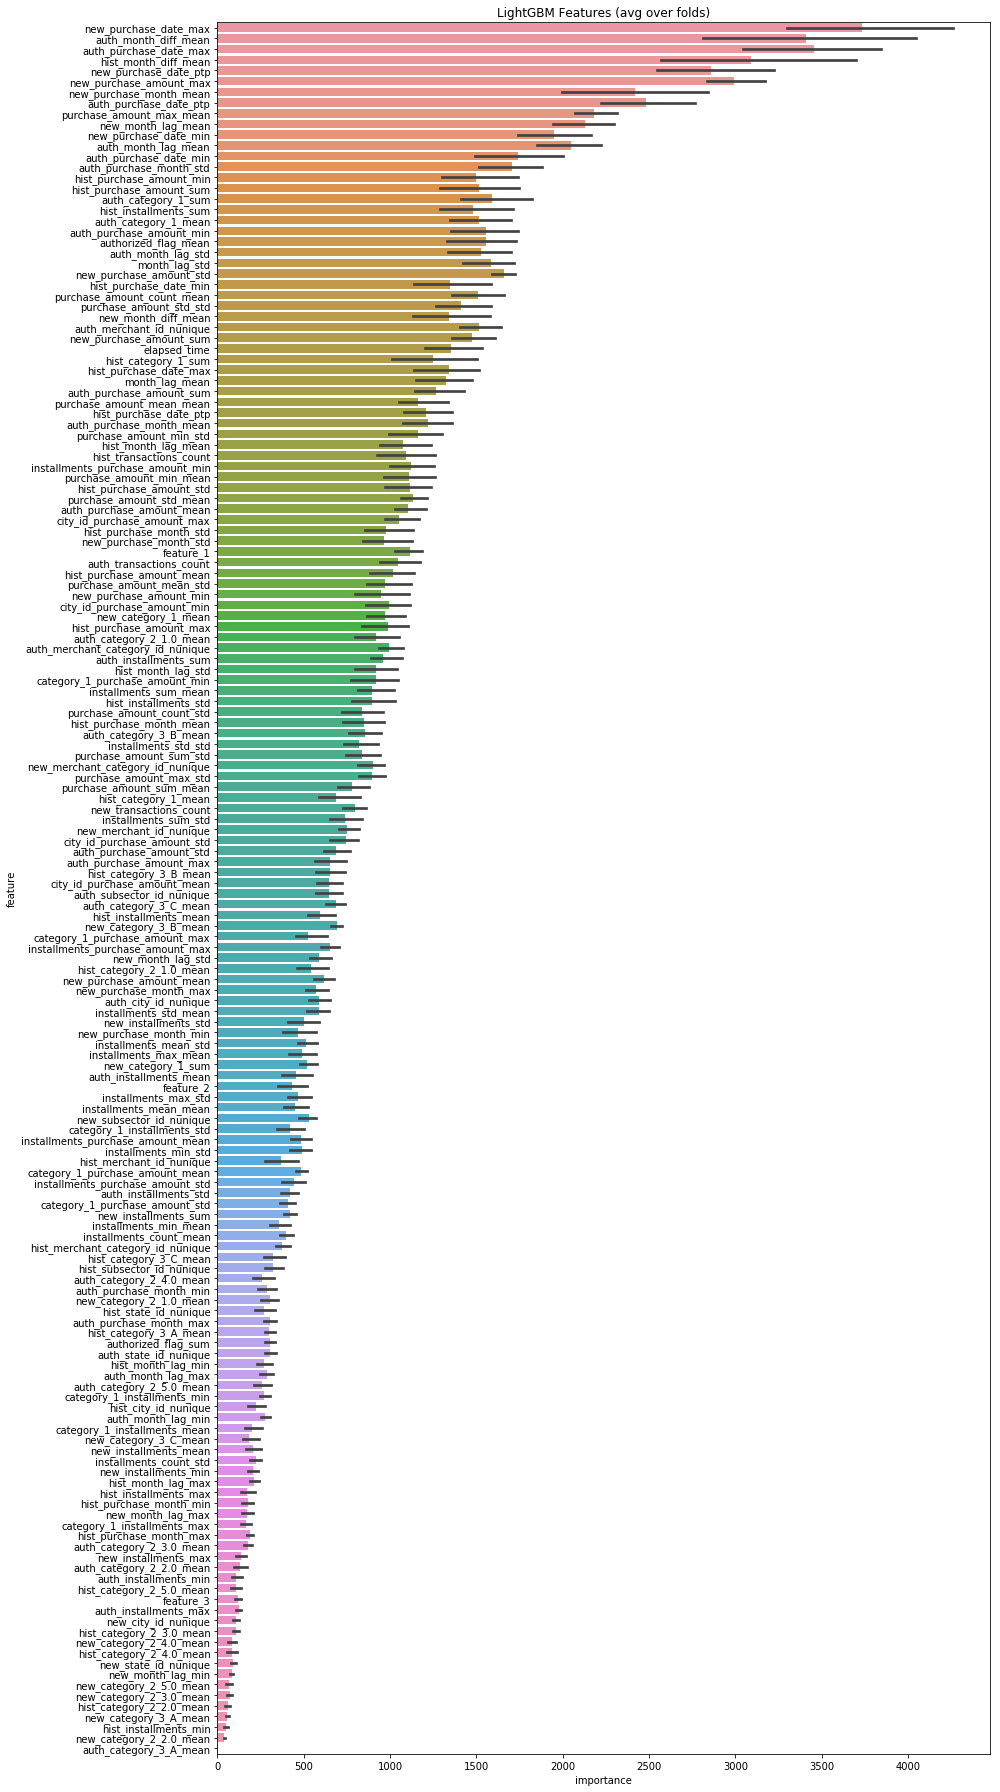

In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)